# EE551 Project Report

***Project name: Emotion Analysis Based on Facial Expression***

**Author: Han Yang, Shulin Yang**

## Introduction

Extracting and validating emotional cues through analysis of users' facial expressions is of high importance for improving the level of interaction in man machine communication systems. A facial expression is one or more motions or positions of the muscles beneath the skin of the face, and we can recognize which kind of emotion the target belongs to rely on the database.

According to the project we are working on, we define that each person has seven kinds of emotions such as neutral, happy, sad, angry and so on, each of which is valued by machine in order to give users the level of emotions.


## Details of dataset and learning algorithms

### Data

**This data is from Kaggle Facial Expression Recognition Challenge, which comprises 48-by-48-pixel grayscale images of human faces, each labeled wigh one of 7 emotion categories: anger, disgust, fear, happiness, sadness, surprise, and neutral.**

**In the data, we have training set of 28709 examples validation set of 3589 examples and test set of 3589 examples including pixels and emotion classification.**

**Dataset resource:** [data](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge)

In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.
/Applications/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


**Use tarfile package to read .tar file and use pandas to read the details**

In [2]:
tar = tarfile.open("fer2013.tar")
df = pd.read_csv(tar.extractfile("fer2013/fer2013.csv"))
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


**Number of whole samples.**

In [3]:
df["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

**Check if there are Null values in training sample**

In [4]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

**Form training set**

In [5]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

**Form validation set**

In [6]:
public_test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]

In [7]:
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(public_test_df["pixels"].values)
y_test = np.array(public_test_df["emotion"])

In [8]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [9]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

**Plot some of the example images**

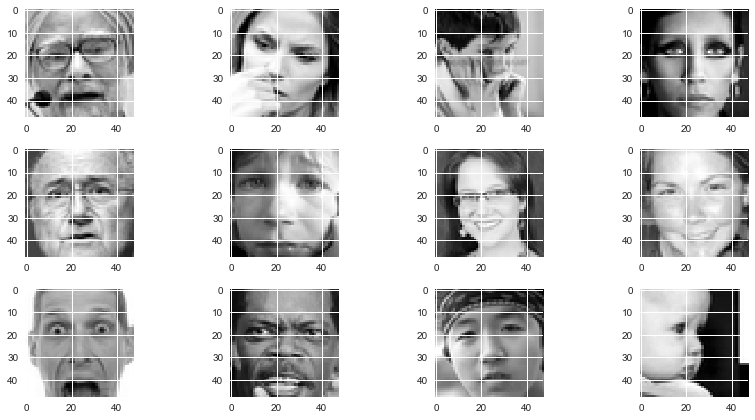

In [10]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

### Learning Algorithms
In this project, we use some methds in deep learning. We create a model with a fixed size of five convolutional layers. In model, we tuned parameters including learning rate, regularization, and dropout. We also used batch normalization and fractional max-pooling.
 * Five-layer CNN
we implemented a first-pass CNN with a fixed depth of five convolutional layers. The architecture is shown as below.

 * Flatten() 
: flatten the input but doesn't affect the batch size

 * Dense()
: just the regular densely-connected NN layer


***Five-layer CNN***

*INPUT(48x48x1)*

CONV3-64

BATCHNORM

RELU

CONV3-64

BATCHNORM

RELU

MAX-POOL

DROPOUT

CONV3-32

BATCHNORM

RELU

CONV3-32

BATCHNORM

RELU

CONV3-32

BATCHNORM

RELU

MAX-POOL

DROPOUT

FLATTEN

DENSE(128)

BATCHNORM

RELU

DROPOUT

DENSE(7)

SOFTMAX



In [11]:
model = Sequential()

model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
__________

**After we implemented the model, it shows the total number of parameters and the details of them.**

**We set 10 as our number of training times. After each iteration, save the best parameters and model.**

In [12]:
# save best weights
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 10

# run model
hist = model.fit(x_train, y_train, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
Epoch 00001: val_loss improved from inf to 1.59643, saving model to face_model.h5
 - 1283s - loss: 1.9936 - acc: 0.2554 - val_loss: 1.5964 - val_acc: 0.3865
Epoch 2/10
Epoch 00002: val_loss improved from 1.59643 to 1.48107, saving model to face_model.h5
 - 1002s - loss: 1.6323 - acc: 0.3612 - val_loss: 1.4811 - val_acc: 0.4391
Epoch 3/10
Epoch 00003: val_loss improved from 1.48107 to 1.47881, saving model to face_model.h5
 - 1054s - loss: 1.5093 - acc: 0.4121 - val_loss: 1.4788 - val_acc: 0.4174
Epoch 4/10
Epoch 00004: val_loss improved from 1.47881 to 1.31048, saving model to face_model.h5
 - 1014s - loss: 1.4433 - acc: 0.4389 - val_loss: 1.3105 - val_acc: 0.4976
Epoch 5/10
Epoch 00005: val_loss improved from 1.31048 to 1.30606, saving model to face_model.h5
 - 981s - loss: 1.3899 - acc: 0.4626 - val_loss: 1.3061 - val_acc: 0.4909
Epoch 6/10
Epoch 00006: val_loss improved from 1.30606 to 1.26353, saving model to face_model.h5

**Plot how the accuracy and loss change during the 10 ierations**

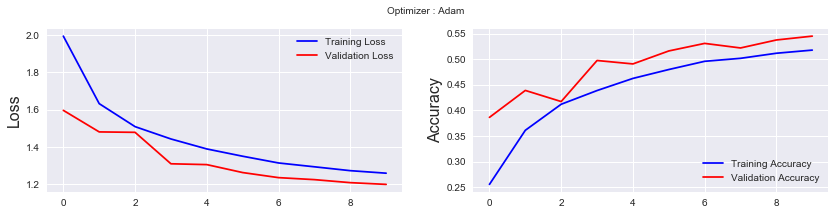

In [13]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

**We can see that during iterations of validation the loss is decreasing and accuray increases. We trained for 10 epochs on each run, saving full run history and saving the model's best weights in HDF5 format. Initially, we were tuning parameters on 10% of the data. However, we realized that these parameters were not generalizing well may because of the incompletely shuffled, so the last half of parameter tuning was done on the full data set. **

**Form test set**

In [14]:
test = df[["emotion", "pixels"]][df["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [15]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [16]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

**Use trained model to predict test samples**

In [17]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
score

[1.1672140293780326, 0.54332683199492959]

## Summary

**In this project, we aim to classify images of faces into any of seven discrete emotion categories. With applying sevral techniques such as CNN model, fine-tuning and fractional max-pooling, we got the accuracy best as 0.54. As is recorded, the highest accuracy rate is 0.71, we think we still have a lot of things to improve.**